In [1]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time

In [2]:
style.use("ggplot")

In [3]:
SIZE = 10

In [4]:
HM_EPISODES = 25000
MOVE_PENALTY = 1
ENEMY_PENALTY = 300
FOOD_REWARD = 25

In [5]:
epsilon = 0.9
EPS_DECAY = 0.9998
SHOW_EVERY = 3000

start_q_table  = None

In [6]:
lr_rate = 0.1
gamma = 0.95

In [7]:
player_n = 1
food_n = 2
enemy_n = 3


In [8]:
d = {1:(255,175,0),
    2:(0,255,0),
    3:(0,0,255)}

In [9]:
class Blob:
    def __init__(self):
        self.x = np.random.randint(0,SIZE)
        self.y = np.random.randint(0,SIZE)
    def __str__(self):
        return f"{self.x},{self.y}"
    def __sub__(self,other):
        return (self.x - other.x,self.y - other.y)
    def action(self,choice):
        if choice == 0:
            self.move(x = 1, y = 1)
        elif choice == 1:
            self.move(x = -1, y = -1)
        elif choice == 2:
            self.move(x = -1, y = 1)
        elif choice == 3:
            self.move(x = 1, y = -1)
        
    def move(self,x = False, y=False):
        if not x:
            self.x += np.random.randint(-1,2)
        else:
            self.x += x
        if not y:
            self.y += np.random.randint(-1,2)
        else:
            self.y += y
        
        if self.x <0:
            self.x = 0
        elif self.x > SIZE - 1:
            self.x = SIZE - 1
        
        if self.y <0:
            self.y = 0
        elif self.y > SIZE - 1:
            self.y = SIZE - 1

In [10]:
if start_q_table is None:
    q_table = {}
    for x1 in range(-SIZE+1,SIZE):
        for y1 in range(-SIZE+1,SIZE):
            for x2 in range(-SIZE+1,SIZE):
                for y2 in range(-SIZE+1,SIZE):
                    q_table[((x1,y1),(x2,y2))] = [np.random.uniform(-5,0) for i in range(4)]
        
else:
    with open(start_q_table,"rb") as f:
        q_table = pickle.load(f)

on # 0, epsilon0.9
3000 ep mean nan


C:\Users\Debanik Roy\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Debanik Roy\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


on # 3000, epsilon0.49390083359356435
3000 ep mean -614.0846666666666
on # 6000, epsilon0.27104225936046566
3000 ep mean -197.84633333333332
on # 9000, epsilon0.14874221981913022
3000 ep mean 68.63633333333334
on # 12000, epsilon0.08162656262136181
3000 ep mean 189.961
on # 15000, epsilon0.044794919246742226
3000 ep mean 262.59633333333335
on # 18000, epsilon0.024582497729691496
3000 ep mean 268.8883333333333
on # 21000, epsilon0.01349035124500733
3000 ep mean 287.6213333333333
on # 24000, epsilon0.0074032174726434705
3000 ep mean 288.00266666666664


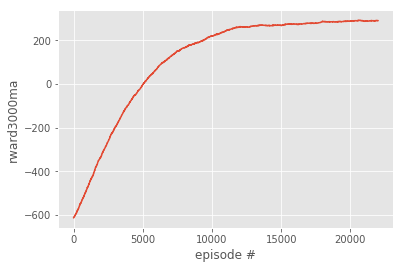

In [11]:
episode_rewards = []
for episode in range(HM_EPISODES):
    player = Blob()
    food = Blob()
    enemy = Blob()
    
    if episode % SHOW_EVERY == 0:
        print(f"on # {episode}, epsilon{epsilon}")
        print(f"{SHOW_EVERY} ep mean {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False
    episode_reward = 0
    for i in range(200):
        obs = (player - food, player - enemy)
        if np.random.random() > epsilon:
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0, 4)
        player.action(action)
        enemy.move()
        food.move()
        
        
        if player.x == enemy.x and player.y == enemy.y:
            reward = -ENEMY_PENALTY
        elif player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD
        else:
            reward = -MOVE_PENALTY
        new_obs = (player-food,player-enemy)
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][action]
        
        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        elif reward == -ENEMY_PENALTY:
            new_q = -ENEMY_PENALTY
        else:
            new_q = (1 - lr_rate)*(current_q) + lr_rate*(reward + gamma*max_future_q)
        
        q_table[obs][action] = new_q
        
        if show:
            env = np.zeros((SIZE,SIZE,3),dtype =np.uint8 )
            env[food.y,food.x] = d[food_n]
            env[player.y,player.x] = d[player_n]
            env[enemy.y,enemy.x] = d[enemy_n]
            
            img = Image.fromarray(env,"RGB")
            img = img.resize((300,300))
            cv2.imshow("img",np.array(img))
            
            if reward == FOOD_REWARD and reward == -ENEMY_PENALTY:
                if cv2.waitKey(500) & 0xFF == ord("q"):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord("q"):
                    break
        episode_reward += reward
        if reward ==FOOD_REWARD & reward == -ENEMY_PENALTY:
            break
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY
moving_avg = np.convolve(episode_rewards,np.ones((SHOW_EVERY,))/SHOW_EVERY,mode="valid")
plt.plot([i for i in range(len(moving_avg))],moving_avg)
plt.ylabel(f"rward{SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()

with open(f"qtable-{int(time.time())}.pickle","wb") as f:
    pickle.dump(q_table,f)